In [ ]:
import ast
import numpy as np
import time
import sys
import pandas as pd
import subprocess
import pickle
import random as rand
import matplotlib.pyplot as plt
import time
import math
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
%config InlineBackend.figure_format='retina'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
ratio = len(inv_16) - sum(inv_16), sum(inv_16)
print(ratio)

(659, 32)


In [ ]:
# Google Colab
%cd "drive/My Drive/internship-2020"

/content/drive/My Drive/internship-2020


In [ ]:
# Simplified rewrite of splitting & oversampling code
from inv16_data_loading import km_normed_1, inv_16

# TESTING: shuffle original label
# np.random.shuffle(inv_16)

# shuffle dataset

# Test split sizes (add up to 1)
train_size = 0.6
valid_size = 0.2
test_size = 0.2

# Separating out negatives & positives
negatives = []
positives = []
for pat_i in range(len(km_normed_1)):
    if inv_16[pat_i] == 1:
        if len(positives) == 0:
            positives = np.concatenate((positives, np.array(km_normed_1.iloc[pat_i])))
        else:
            positives = np.vstack((positives, np.array(km_normed_1.iloc[pat_i])))
    elif inv_16[pat_i] == 0:
        if len(negatives) == 0:
            negatives = np.concatenate((negatives, np.array(km_normed_1.iloc[pat_i])))
        else:
            negatives = np.vstack((negatives, np.array(km_normed_1.iloc[pat_i])))

# Splitting sets
num_pos = len(positives)
num_neg = len(negatives)
sum_sizes = train_size + valid_size + test_size
ps1, ps2 = math.floor(train_size*num_pos), math.floor((train_size+valid_size)*num_pos)
ns1, ns2 = math.floor(train_size*num_neg), math.floor((train_size+valid_size)*num_neg)
train_set = np.concatenate((negatives[:ns1], positives[:ps1]))
valid_set = np.concatenate((negatives[ns1:ns2], positives[ps1:ps2]))
test_set = np.concatenate((negatives[ns2:], positives[ps2:]))
n_neg_train, n_neg_val, n_neg_test = ns1, (ns2-ns1), (num_neg-ns2)
n_pos_train, n_pos_val, n_pos_test = ps1, (ps2-ps1), (num_pos-ps2)
train_label = [0] * n_neg_train + [1] * n_pos_train
valid_label = [0] * n_neg_val + [1] * n_pos_val
test_label = [0] * n_neg_test + [1] * n_pos_test

# TESTING: shuffle after splitting
# rand.shuffle(train_label)
# rand.shuffle(valid_label)
# rand.shuffle(test_label)

# Oversample each set
n_extra_pos_train, n_extra_pos_val, n_extra_pos_test = n_neg_train-n_pos_train, n_neg_val-n_pos_val, n_neg_test-n_pos_test
over_train = np.array([]).reshape((0,km_normed_1.shape[1]))
over_valid = np.array([]).reshape((0,km_normed_1.shape[1]))
over_test = np.array([]).reshape((0,km_normed_1.shape[1]))
i,j,k = 0,0,0
while len(over_train) < n_extra_pos_train:
    over_train = np.concatenate((over_train, train_set[n_neg_train + i % n_pos_train].reshape(1,km_normed_1.shape[1])))
    train_label += [1]
    i += 1
while len(over_valid) < n_extra_pos_val:
    over_valid = np.concatenate((over_valid, valid_set[n_neg_val + j % n_pos_val].reshape(1,km_normed_1.shape[1])))
    valid_label += [1]
    j += 1
while len(over_test) < n_extra_pos_test:
    over_test = np.concatenate((over_test, test_set[n_neg_test + k % n_pos_test].reshape(1,km_normed_1.shape[1])))
    test_label += [1]
    k += 1
oc_train_set = np.concatenate((train_set, over_train))
oc_valid_set = np.concatenate((valid_set, over_valid))
oc_test_set = np.concatenate((test_set, over_test))

# TESTING: shuffle after oversampling
# rand.shuffle(train_label)
# rand.shuffle(valid_label)
# rand.shuffle(test_label)

train_and_label = [(oc_train_set[i],train_label[i]) for i in range(len(train_label))]
valid_and_label = [(oc_valid_set[i],valid_label[i]) for i in range(len(valid_label))]
test_and_label = [(oc_test_set[i],test_label[i]) for i in range(len(test_label))]

# Data samplers & loaders
batch_size = 64
num_workers = 0
train_sampler = SubsetRandomSampler(range(len(train_and_label)))
valid_sampler = SubsetRandomSampler(range(len(valid_and_label)))
test_sampler = SubsetRandomSampler(range(len(test_and_label)))
train_loader = torch.utils.data.DataLoader(train_and_label,
                                           batch_size=batch_size,
                                           sampler=train_sampler,
                                           num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_and_label,
                                           batch_size=batch_size,
                                           sampler=valid_sampler,
                                           num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_and_label,
                                           batch_size=batch_size,
                                           sampler=test_sampler,
                                           num_workers=num_workers)

In [ ]:
print(train_set.shape)
print(valid_set.shape)
print(test_set.shape)
print(ns1, ns2, ps1, ps2)
print(len(train_label), len(valid_label), len(test_label))
print(train_label[ns1])

(414, 9995)
(138, 9995)
(139, 9995)
395 527 19 25
790 264 264
1


### Data Visualisation

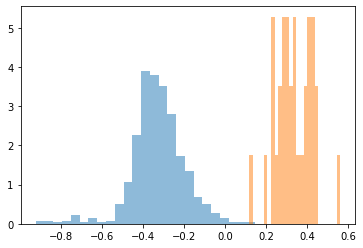

In [ ]:
plt.hist(np.median(negatives,axis=1), bins=25, alpha = 0.5, label='negatives', density=True)
plt.hist(np.median(positives,axis=1), bins=25, alpha = 0.5, label='positives', density=True)
plt.show()

In [ ]:
def compare_kmer_plot(i):
    print(i)
    plt.hist(negatives[:,i], bins=100, alpha = 0.5, label='negatives', density=True)
    plt.hist(positives[:,i], bins=25, alpha = 0.5, label='positives', density=True)
    plt.show()

4088


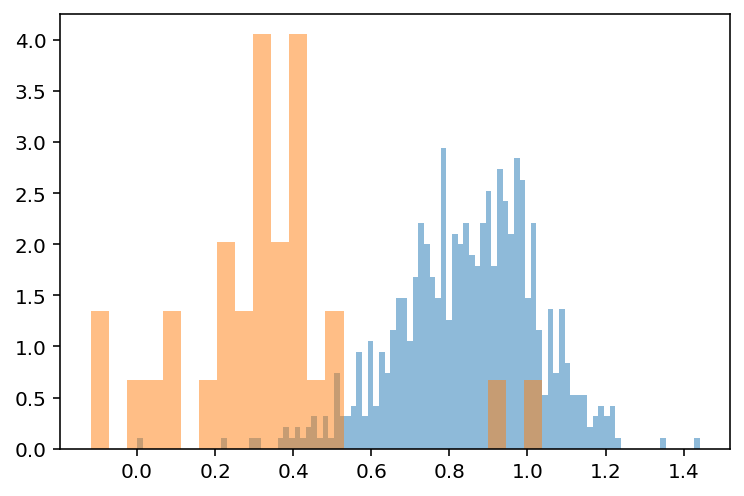

9261


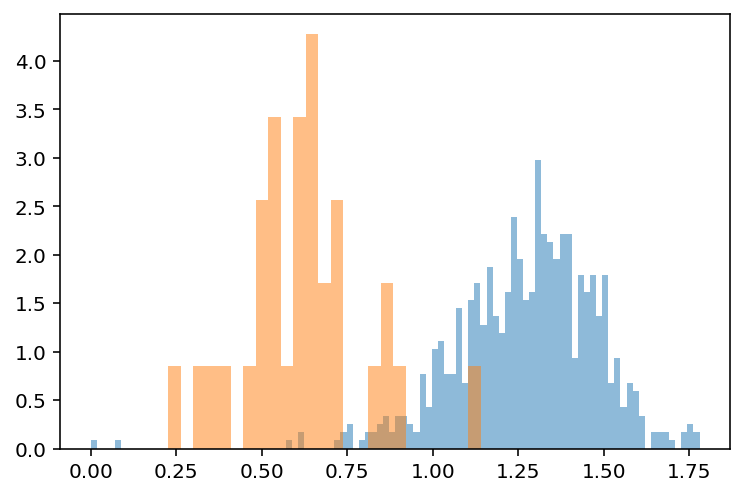

2863


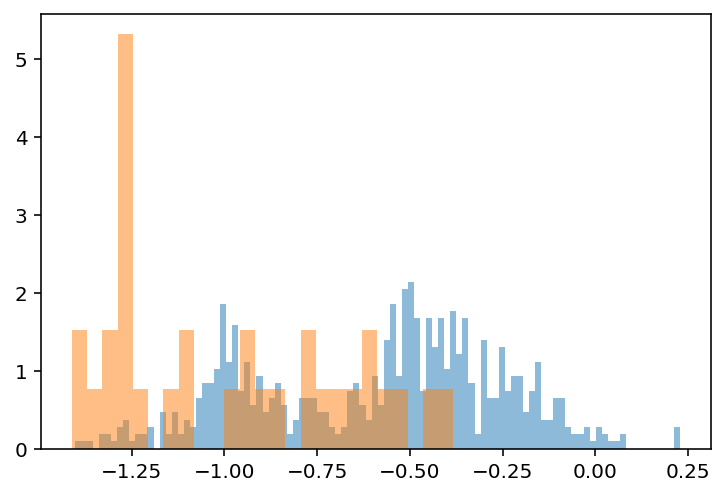

665


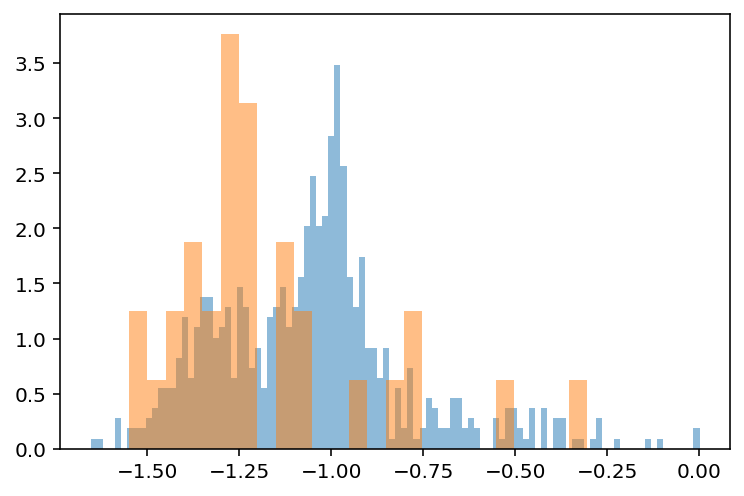

2046


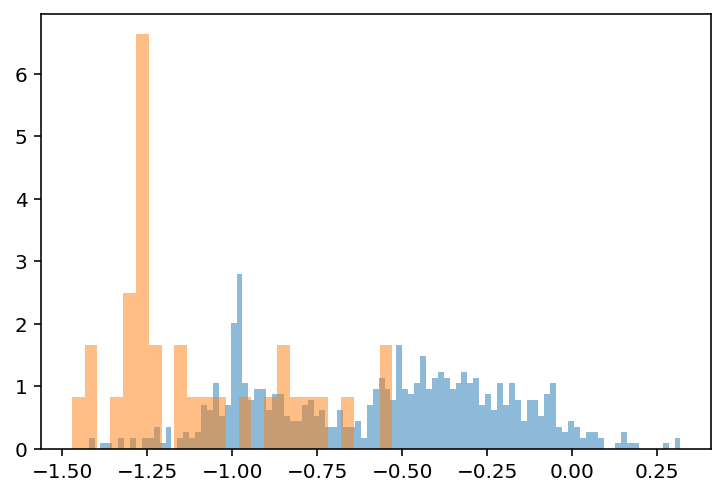

7072


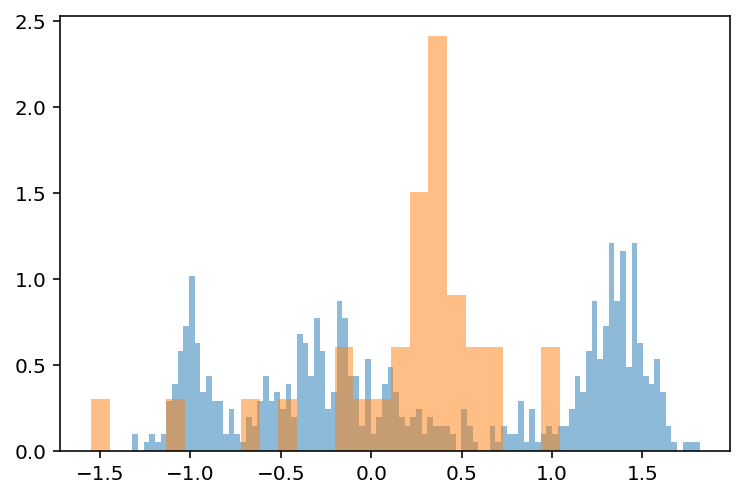

4894


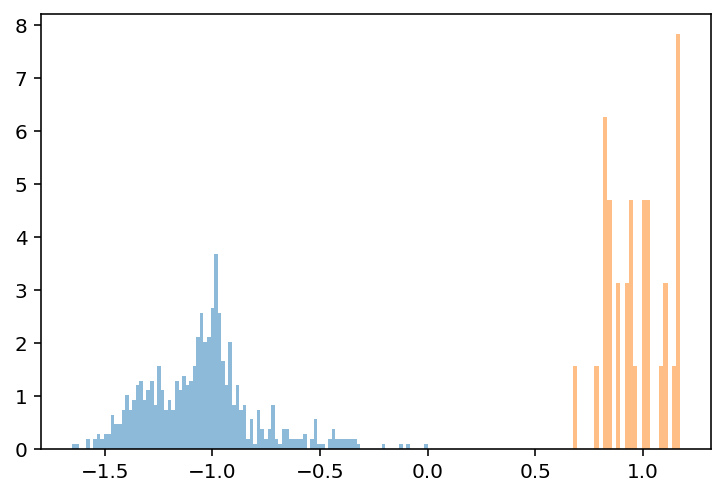

1364


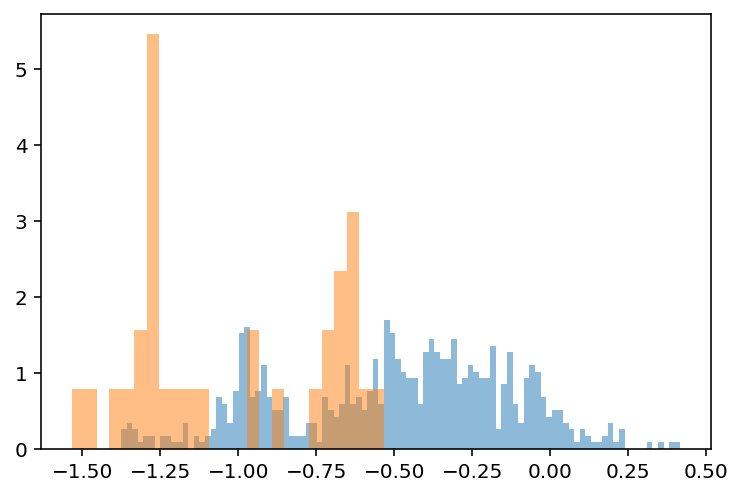

7819


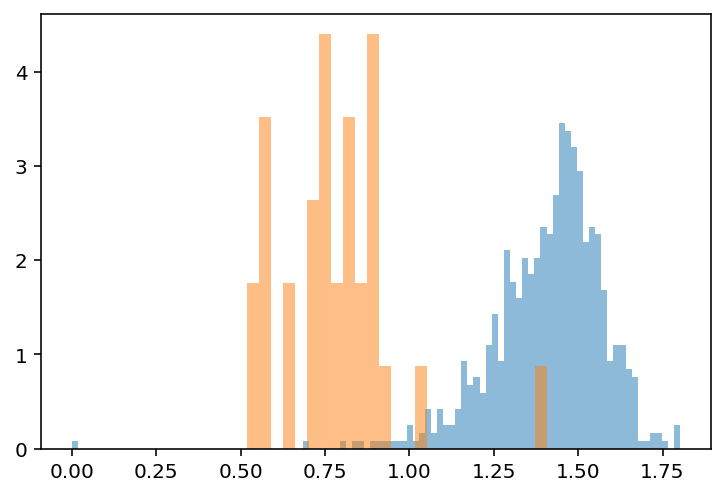

504


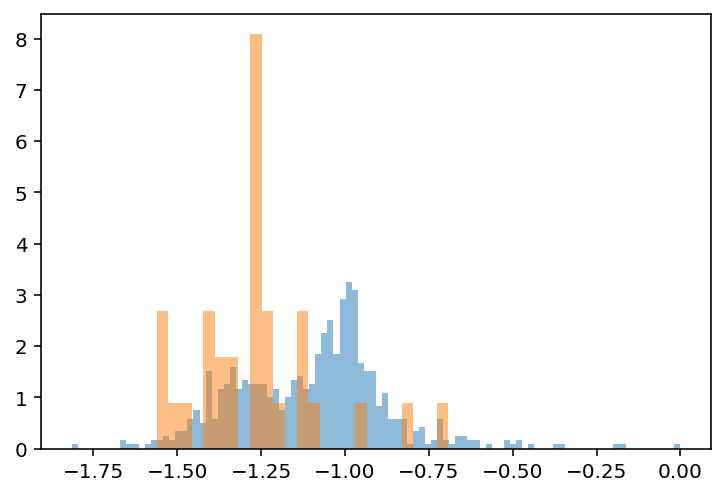

In [ ]:
for i in range(10):
    compare_kmer_plot(rand.randrange(0,km_normed_1.shape[1]))

In [ ]:
# Difference in means per kmer between positive and negative examples
diff_pos_neg = np.abs(np.mean(positives, axis=0) - np.mean(negatives, axis=0))

In [ ]:
for param in model.parameters():
    input_weights = param.data
    break
print(input_weights.shape)
input_weights = input_weights.cpu()

NameError: ignored

In [ ]:
# Sum of all weights for a single input neuron (kmer)
sum_weights = np.sum(np.array(input_weights), axis=0)

NameError: ignored

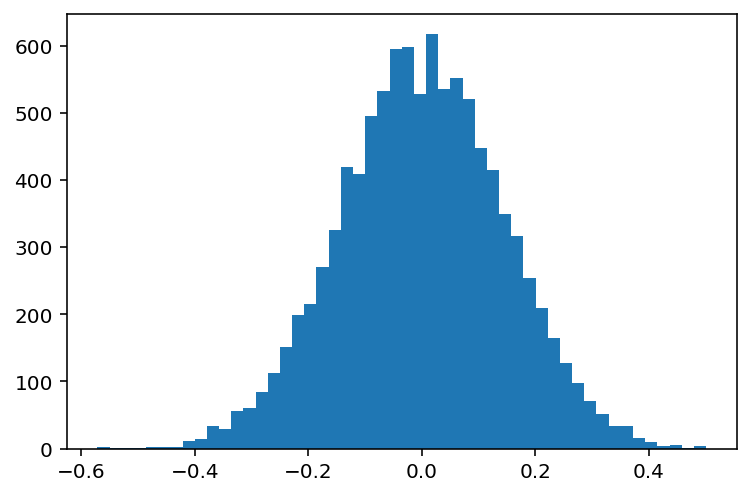

In [ ]:
plt.hist(sum_weights, bins=50)
plt.show()

0.6770142120755103


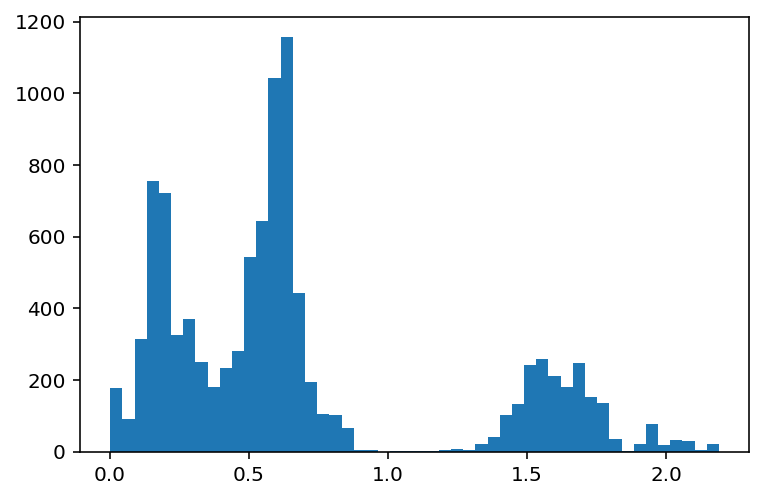

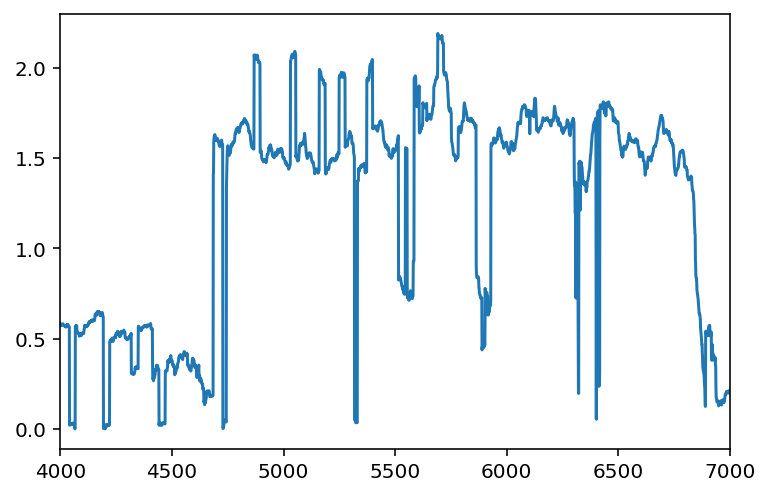

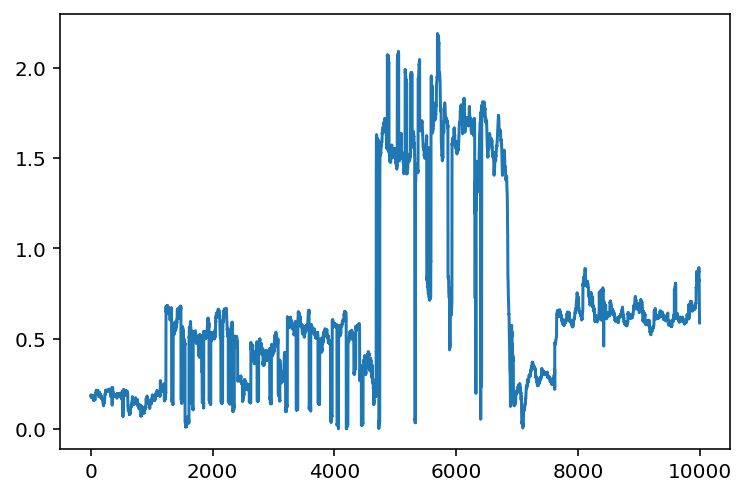

In [ ]:
print(np.mean(diff_pos_neg))
plt.hist(diff_pos_neg, bins=50)
plt.show()
#plt.plot(sum_weights)
plt.plot(diff_pos_neg)
plt.xlim(4000, 7000)
plt.show()
#plt.plot(sum_weights)
plt.plot(diff_pos_neg)
plt.show()

### Checking that sets are separate



In [ ]:
tag = []
for pat in data:
    tag.append(pat[0][-1])
from collections import Counter
counter = Counter()
for t in tag:
    counter[t] += 1

In [ ]:
t_set, v_set = set(), set()
for ti in train_idx:
    t_set.add(int(tag[ti]))
for vi in valid_idx:
    v_set.add(int(tag[vi]))
print(t_set.intersection(v_set))
print(len(t_set))
print(len(v_set))

set()
552
139


In [ ]:
t_set, v_set = set(), set()
for d, t in train_loader:
    for line in d:
        t_set.add(int(line[-1]))
for d, t in valid_loader:
    for line in d:
        v_set.add(int(line[-1]))
print(t_set.intersection(v_set))
print(len(t_set))
print(len(v_set))

set()
552
139


In [ ]:
np.array(sorted(list(t_set))) == np.array(sorted(list(train_idx)[:552]))

In [ ]:
len(valid_idx)

264

In [ ]:
print(len(train_idx), len(valid_idx))
print(sum(oc_inv_16) / len(oc_inv_16))

1054 264
0.5


In [ ]:
# Ensuring separate sets
print(set(pos_train).intersection(set(pos_val)))
print(set(neg_train).intersection(set(neg_val)))
print(set(pos_train).intersection(set(neg_val)))
print(set(pos_train).intersection(set(neg_train)))
print(set(pos_val).intersection(set(neg_val)))
print(set([1, 2, 3, 4, 5]).intersection(set([0, 3, 6, 7, 1])))

set()
set()
set()
set()
set()
{1, 3}


### Debugging

In [ ]:
torch.cuda.is_available()

True

In [ ]:
def remove_tag(data, s):
    # taking out tag
    print(f"New {s} batch!")
    tags = [chr(i) for i in data[:,-1]]
    print(" ".join(tags))
    return data[:,:-1]

In [ ]:
%pdb

Automatic pdb calling has been turned OFF


### Running model

In [ ]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"
device = torch.device(dev)

# 4 layers sgd lr=0.01 and no dropout
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(km_normed_1.shape[1], 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 8)
        self.fc5 = nn.Linear(8, 2)
        #self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        #x = self.dropout(x)
        x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        x = F.relu(self.fc3(x))
        #x = self.dropout(x)
        x = F.relu(self.fc4(x))
        #x = self.dropout(x)
        x = self.fc5(x)
        return x
    
    def predict(self,x):
        pred = F.softmax(self.forward(x), dim=1)
        ans = []
        for t in pred:
            if t[0]>t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

n_epochs = 100
valid_loss_min = np.Inf
t_losses = []
v_losses = []

model = Net()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    # Training
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data.float())
        target = target.long()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # Validation
    model.eval()
    for data, target in valid_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data.float())
        target = target.long()
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        
    # Saving loss for validation graph
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    t_losses.append(train_loss)
    v_losses.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss < valid_loss_min:
        torch.save(model.state_dict(), 'model_files/model_inv16_3.pt')
        valid_loss_min = valid_loss
    
    # Progress bar
    print(f"\rEpoch: {epoch+1}\tTrain: {train_loss}\tVal: {valid_loss}\tMin Val: {valid_loss_min}", end='')
print("")
torch.save(model.state_dict(), 'model_files/model_inv16_3.pt')

# Final model
model.load_state_dict(torch.load('model_files/model_inv16_3.pt'))
from sklearn.metrics import roc_auc_score
model.eval()
score = 0
for data, target in test_loader:
    data = data.to(device)
    pred = model.predict(data.float())
    pred.cpu()
    score += roc_auc_score(pred, target)*len(target)
    #print(roc_auc_score(pred, target))
    print(pred)
    print(target)
print('\n', score/len(test_loader.sampler))

# Saved best model
model.load_state_dict(torch.load('model_files/model_inv16_3.pt'))
model.eval()
score = 0
for data, target in test_loader:
    data = data.to(device)
    data.float()
    pred = model.predict(data.float())
    pred.cpu()
    score += roc_auc_score(pred, target)*len(target)
    #print(roc_auc_score(pred, target))
    print(pred)
    print(target)
print('\n', score/len(test_loader.sampler))

# Validation graph
plt.plot(t_losses)
plt.plot(v_losses)
plt.ylim(0,1)
plt.show()

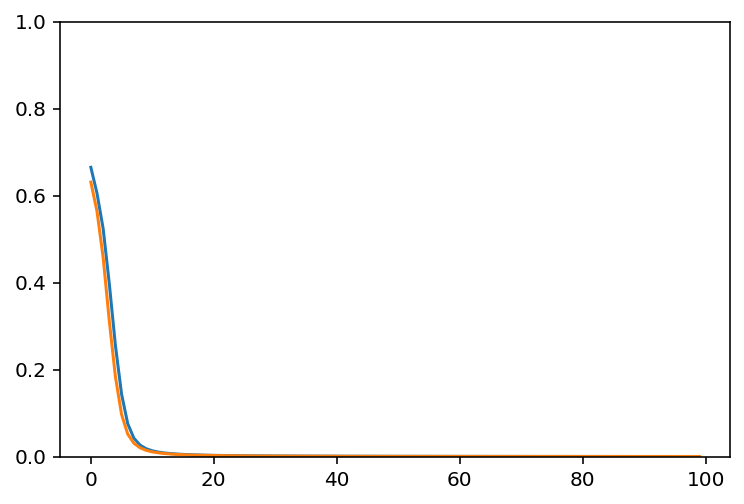

In [ ]:
# Original result
plt.plot(t_losses)
plt.plot(v_losses)
plt.ylim(0,1)
plt.show()

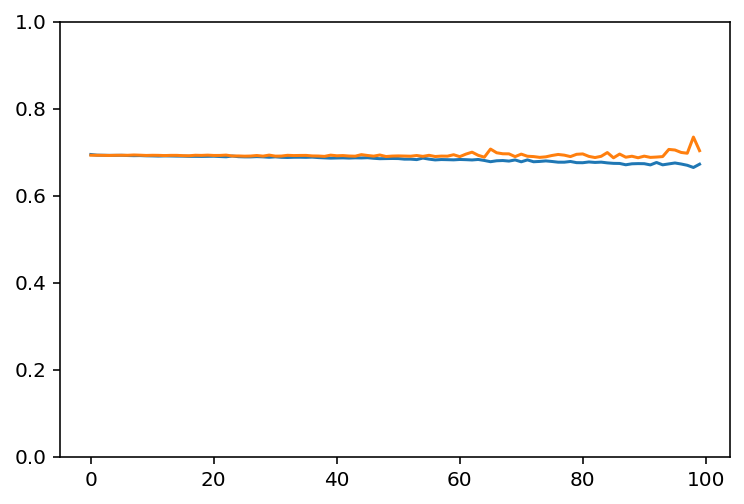

In [ ]:
# Shuffling after oversampling (all 0)
plt.plot(t_losses)
plt.plot(v_losses)
plt.ylim(0,1)
plt.show()

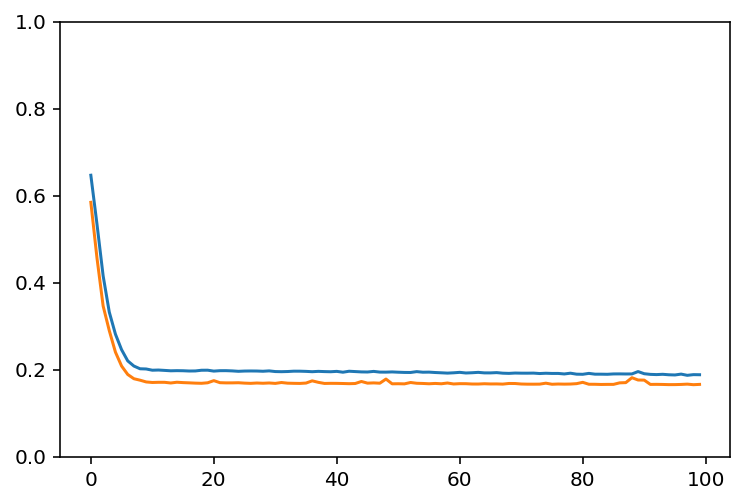

In [ ]:
# Shuffling after splitting (0.94 ROCAUC)
plt.plot(t_losses)
plt.plot(v_losses)
plt.ylim(0,1)
plt.show()

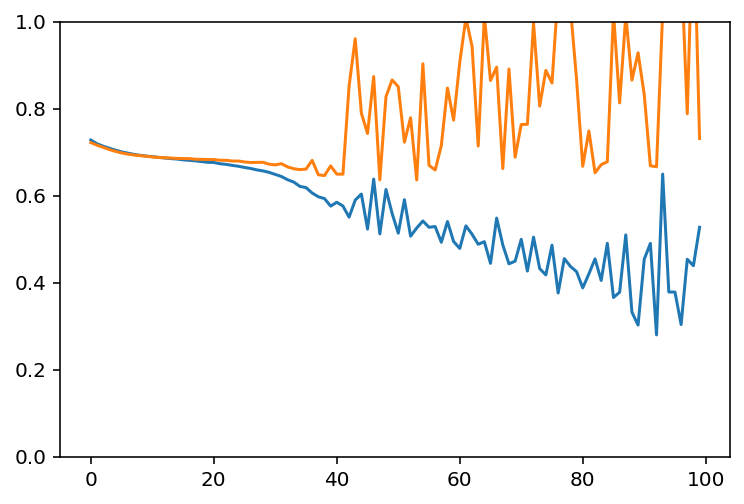

In [ ]:
# Shuffling at the beginning (only predicts 0)
plt.plot(t_losses)
plt.plot(v_losses)
plt.ylim(0,1)
plt.show()
# put systematic testing inside a table
# with and without everything, shuffle at various places, run code with random shuffles multiple times
# Organize the code